# Gráficas para estudio de reservas en Guatemala

In [144]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import datetime
import matplotlib.dates as mdates

In [ ]:
reservas = pd.read_excel("db/datos_reservas.xlsx")

In [ ]:
reservas

In [ ]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=reservas.melt('Mes', var_name='Año', value_name='Reservas'), x='Mes', y='Reservas', hue='Año', marker='o', palette=["#19315F", "#F48401", "#BDDB05", "#11C876", "#879484", "#BC2EE6", "#621A22"])

plt.xticks(rotation=45)
plt.title('Reservas Bancarias por Año')
plt.xlabel('Mes')
plt.ylabel('Reservas en millones de quetzales')

# Mueve la leyenda fuera del gráfico, a la parte superior derecha
plt.legend(title='Año', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Calcular variaciones intermensuales e interanuales

In [ ]:
# Variaciones intermensuales
int_mensuales = reservas[[i for i in range(2018, 2024)]].diff().fillna(0)
int_mensuales

In [ ]:
# Hacer diccionario con estadísticos por año
est_anuales = {i: [0,0,0,0] for i in range(2018,2024)}
for i in range(2018, 2024):
    est_anuales[i][0] = reservas[i].mean()
    est_anuales[i][1] = reservas[i].var()
    est_anuales[i][2] = reservas[i].min()
    est_anuales[i][3] = reservas[i].max()

df_est_anuales = pd.DataFrame.from_dict(est_anuales, orient="index", columns=["Promedio", "Varianza", "Mínimo", "Máximo"])
df_est_anuales.index.name = "Año"

df_est_anuales

## Análisis de reservas e inflación

In [ ]:
reservas_iniciales_anuales = reservas[reservas["Mes"] == "Enero"]
ritmo_inflacionario = pd.read_excel("db/Ritmo_inflacionario.xlsx")

In [ ]:
ritmo_inflacionario

In [ ]:
dic_proyeccion = {i: [None]*12 for i in range(2018, 2024)}
dic_proyeccion["Mes"] = ritmo_inflacionario["Año"].tolist()
df_proyeccion = pd.DataFrame.from_dict(dic_proyeccion)
df_proyeccion = df_proyeccion[["Mes", 2018, 2019, 2020, 2021, 2022, 2023]]

In [ ]:
for i in range(2018, 2024):
    for j in range(0, 12):
        if j == 0:
            df_proyeccion.loc[0, i] = reservas.loc[0, i]
        else:
           df_proyeccion.loc[j, i] = df_proyeccion.loc[j-1, i] * (1 + ritmo_inflacionario.loc[j-1,i] / 100)

In [ ]:
df_proyeccion

In [ ]:
# Combinar dfs para poder graficar
df_combinado = reservas.join(df_proyeccion, lsuffix="_re", rsuffix="_pro")
plt.figure(figsize=(10, 12))

for year in range(2018, 2024):  # Asumiendo que tienes datos de 2018 a 2023.
    plt.figure(figsize=(10, 5))  # Crea una nueva figura para cada año.
    plt.plot(df_combinado["Mes_re"], df_combinado[str(year) + '_re'], marker='o', label='Reservas reportadas', color="#FF0000")
    plt.plot(df_combinado["Mes_re"], df_combinado[str(year) + '_pro'], marker='o', linestyle='--', label='Proyección con ritmo inflacionario', color="#0000ff")
    
    plt.title(f'Reservas Bancarias - {year}')
    plt.xlabel('Mes')
    plt.xticks(rotation=25)
    plt.ylabel('Reservas en millones de quetzales')
    plt.legend()
    plt.grid(True)
    
    # Guarda la figura en un archivo.
    # Reemplaza 'ruta/del/directorio' con la ruta real donde deseas guardar los archivos.
    plt.savefig(f'imagenes/reservas_{year}.png', bbox_inches="tight")
    plt.close()  # Cierra la figura para evitar el sobreplotting.

## Segundo Análsis de inflación

In [ ]:
dic_retro = {i: [None]*12 for i in range(2018, 2024)}
dic_retro["Mes"] = ritmo_inflacionario["Año"].tolist()
df_retro = pd.DataFrame.from_dict(dic_proyeccion)
df_retro = df_retro[["Mes", 2018, 2019, 2020, 2021, 2022, 2023]]

In [ ]:
for i in range(2018, 2024):
    for j in range(0, 12):
        if j == 0:
            df_retro.loc[0, i] = reservas.loc[0, i]
        else:
           df_retro.loc[j, i] = df_retro.loc[j-1, i] * (1 - ritmo_inflacionario.loc[j-1,i] / 100)
            

In [ ]:
df_retro

In [ ]:
# Combinar dfs para poder graficar
df_combinado_2 = reservas.join(df_retro, lsuffix="_re", rsuffix="_retro")
plt.figure(figsize=(10, 12))

for year in range(2018, 2024):  # Asumiendo que tienes datos de 2018 a 2023.
    plt.figure(figsize=(10, 5))  # Crea una nueva figura para cada año.
    plt.plot(df_combinado_2["Mes_re"], df_combinado_2[str(year) + '_re'], marker='o', label='Reservas reportadas', color="#FF0000")
    plt.plot(df_combinado_2["Mes_re"], df_combinado_2[str(year) + '_retro'], marker='o', linestyle='--', label='Proyección sin ritmo inflacionario', color="#0000ff")
    
    plt.title(f'Reservas Bancarias - {year}')
    plt.xlabel('Mes')
    plt.xticks(rotation=25)
    plt.ylabel('Reservas en millones de quetzales')
    plt.legend()
    plt.grid(True)
    
    # Guarda la figura en un archivo.
    # Reemplaza 'ruta/del/directorio' con la ruta real donde deseas guardar los archivos.
    plt.savefig(f'imagenes/retro_{year}.png', bbox_inches="tight")
    plt.close()  # Cierra la figura para evitar el sobreplotting.

## Modelo ARIMA

In [133]:
# Retomar los df de ritmo inflacionario y el de reservas para hacer arima
serie_inflacion = []
serie_inflacion_testeo = []
tiempo = []
tiempo_testeo = []

for i in range(2018, 2023):
    serie_inflacion += list(ritmo_inflacionario[i])

for i in range(2023, 2025):
    serie_inflacion_testeo += list(ritmo_inflacionario[i])

for i in range(2018, 2023):
    for j in range(1, 13):
        tiempo.append(f"01/{j}/{i}")


for i in range(2023, 2025):
    for j in range(1, 13):
        tiempo_testeo.append(f"01/{j}/{i}")

# Hacer df para arima con datos de inflacion 
dic_arima_inflacion = {"Tiempo": tiempo, "Inflación": serie_inflacion}
df_arima_inflacion = pd.DataFrame.from_dict(dic_arima_inflacion)
df_arima_inflacion["Tiempo"] = pd.to_datetime(df_arima_inflacion["Tiempo"])
df_arima_inflacion["Inflación"] = df_arima_inflacion["Inflación"].astype("float")
df_arima_inflacion.set_index("Tiempo", inplace=True)

# Hacer df de testeo
dic_arima_inflacion_testeo = {"Tiempo": tiempo_testeo, "Inflación": serie_inflacion_testeo}
df_arima_inflacion_testeo = pd.DataFrame.from_dict(dic_arima_inflacion_testeo)
df_arima_inflacion_testeo["Tiempo"] = pd.to_datetime(df_arima_inflacion_testeo["Tiempo"])
df_arima_inflacion_testeo["Inflación"] = df_arima_inflacion_testeo["Inflación"].astype("float")
df_arima_inflacion_testeo.set_index("Tiempo", inplace=True)

# Repetir para datos de reservas
serie_reservas = []
serie_reservas_testeo = []

for i in range(2018, 2023):
    serie_reservas += list(reservas[i])

for i in range(2023, 2025):
    serie_reservas_testeo += list(reservas[i])

# Hacer df para arima con datos de reservas 
dic_arima_reservas = {"Tiempo": tiempo, "Reservas": serie_reservas}
df_arima_reservas = pd.DataFrame.from_dict(dic_arima_reservas)
df_arima_reservas["Tiempo"] = pd.to_datetime(df_arima_reservas["Tiempo"])
df_arima_reservas["Reservas"] = df_arima_reservas["Reservas"].astype("float")
df_arima_reservas.set_index("Tiempo", inplace=True)


# Hacer df de testeo
dic_arima_reservas_testeo = {"Tiempo": tiempo_testeo, "Reservas": serie_reservas_testeo}
df_arima_reservas_testeo = pd.DataFrame.from_dict(dic_arima_reservas_testeo)
df_arima_reservas_testeo["Tiempo"] = pd.to_datetime(df_arima_reservas_testeo["Tiempo"])
df_arima_reservas_testeo["Reservas"] = df_arima_reservas_testeo["Reservas"].astype("float")
df_arima_reservas_testeo.set_index("Tiempo", inplace=True)

In [ ]:
def hallar_parametros_arima(df, variables):
    modelo_var = {var : (0,0,0) for var in variables}
    for var in variables:
        modelo = auto_arima(df[var], max_p=100, max_d=5, max_q=100)
        modelo_var[var] = modelo.order
    return modelo_var

In [148]:
# Hallar parámetros para arima
parametros_inflacion = hallar_parametros_arima(df_arima_inflacion, ["Inflación"])["Inflación"]
parametros_reservas = hallar_parametros_arima(df_arima_reservas, ["Reservas"])["Reservas"]


# Aplicar ARIMA
modelo_inflacion = ARIMA(df_arima_inflacion, order=parametros_inflacion)
modelo_fit_inflacion = modelo_inflacion.fit()
predicciones_inflacion = modelo_fit_inflacion.forecast(steps=14)

modelo_reservas = ARIMA(df_arima_reservas, order=parametros_reservas)
modelo_fit_reservas = modelo_reservas.fit()
predicciones_reservas = modelo_fit_reservas.forecast(steps=14)

c:\Users\mariajose_chinchilla\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mariajose_chinchilla\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mariajose_chinchilla\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mariajose_chinchilla\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\ba

In [ ]:
# Aplicar SARIMA
model_sarima_inflacion = SARIMAX(df_arima_inflacion["Inflación"], order=parametros_inflacion, seasonal_order=(1,0,1,12))
modelo_fit__sarima_inflacion = model_sarima_inflacion.fit()

# Realizar predicciones
predicciones_sarima_inflacion = modelo_fit__sarima_inflacion.get_forecast(steps=14)
predicciones_sarima_inflacion = predicciones_sarima_inflacion.predicted_mean

# Ahora para reservas
model_sarima_reservas = SARIMAX(df_arima_reservas["Reservas"], order=parametros_reservas, seasonal_order=(1,0,2,12))
modelo_fit__sarima_reservas = model_sarima_reservas.fit()

# Realizar predicciones
predicciones_sarima_reservas = modelo_fit__sarima_reservas.get_forecast(steps=14)
predicciones_sarima_reservas = predicciones_sarima_reservas.predicted_mean

## Graficar proyecciones

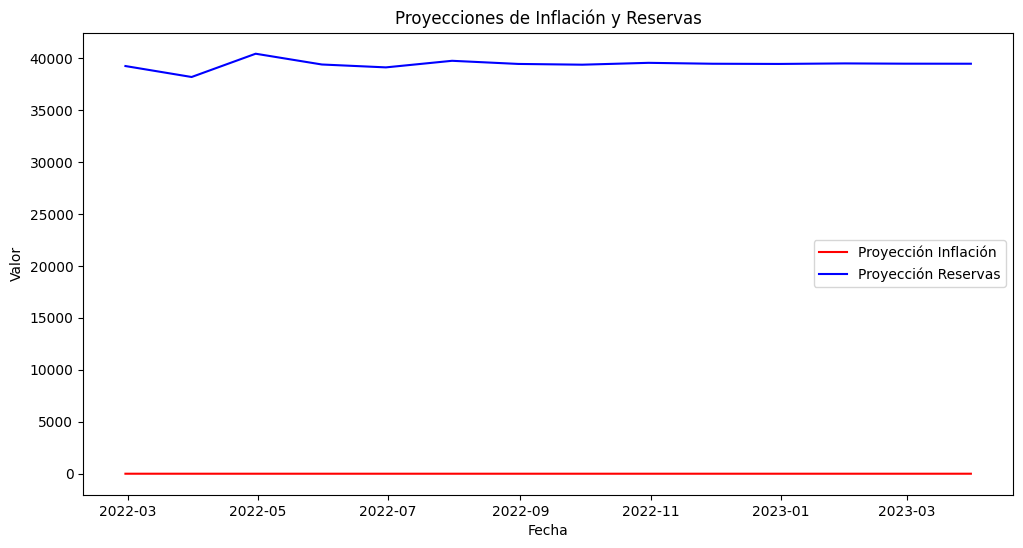

In [154]:
# Genera un rango de fechas para las predicciones. Asegúrate de que 'df_arima_inflacion' y 'df_arima_reservas' tengan un índice de fecha.
fecha_final_inflacion = df_arima_inflacion.index[-1]
fecha_final_reservas = df_arima_reservas.index[-1]
prediccion_fechas_inflacion = pd.date_range(start=fecha_final_inflacion, periods=15, freq='M')[1:]
prediccion_fechas_reservas = pd.date_range(start=fecha_final_reservas, periods=15, freq='M')[1:]

# Crear el gráfico de proyecciones
plt.figure(figsize=(12, 6))

# Graficar la proyección de Inflación
plt.plot(prediccion_fechas_inflacion, predicciones_inflacion, color='red', label='Proyección Inflación')

# Graficar la proyección de Reservas
plt.plot(prediccion_fechas_reservas, predicciones_reservas, color='blue', label='Proyección Reservas')

# Título y leyendas
plt.title('Proyecciones de Inflación y Reservas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Mostrar la gráfica
plt.show()


## Gráficas para SARIMA

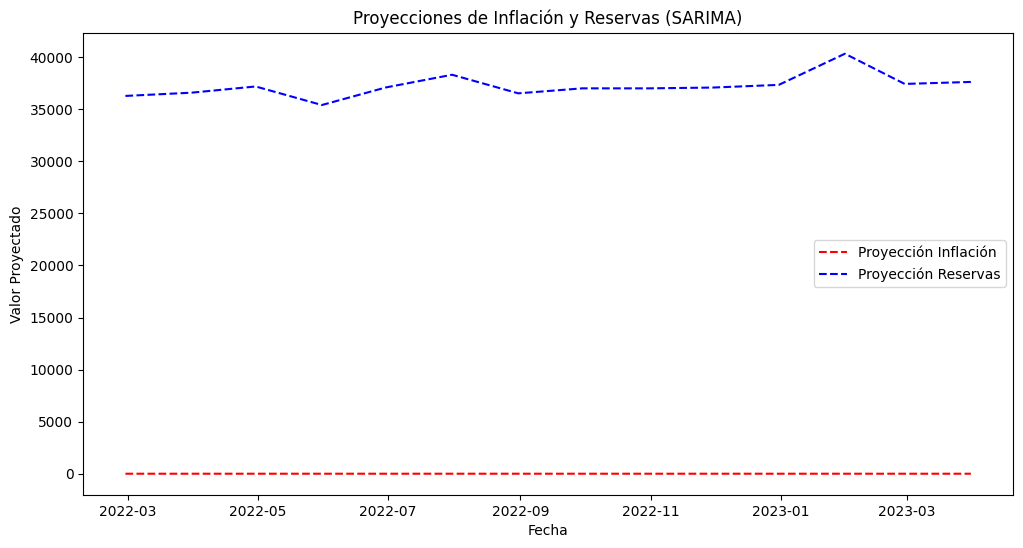

In [156]:
# Generar rango de fechas para las predicciones futuras
fecha_final_inflacion = df_arima_inflacion.index[-1]
fecha_final_reservas = df_arima_reservas.index[-1]
fechas_prediccion_inflacion = pd.date_range(start=fecha_final_inflacion, periods=15, freq='M')[1:]  # 14 pasos más allá de la última fecha
fechas_prediccion_reservas = pd.date_range(start=fecha_final_reservas, periods=15, freq='M')[1:]  # 14 pasos más allá de la última fecha

# Crear figura y ejes
plt.figure(figsize=(12, 6))

# Graficar proyecciones de Inflación
plt.plot(fechas_prediccion_inflacion, predicciones_sarima_inflacion, color='red', linestyle='--', label='Proyección Inflación')

# Graficar proyecciones de Reservas
plt.plot(fechas_prediccion_reservas, predicciones_sarima_reservas, color='blue', linestyle='--', label='Proyección Reservas')

# Título y leyendas
plt.title('Proyecciones de Inflación y Reservas (SARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Valor Proyectado')
plt.legend()

# Mostrar la gráfica
plt.show()
